# data set definitions for rollouts 

> Definitions of various data sets used in learning with offline rollouts.

In [ ]:
#| default_exp data.loaders

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore import *
from fastcore.utils import *

In [ ]:
#| export
from bisect import bisect
from os import listdir
from os.path import join, isdir
from tqdm import tqdm
import torch
import torch.utils.data
import numpy as np


In [ ]:
root = '../marl_grid_data/'
train = True
buffer_size = 10
_files = [join(root, sd) for sd in listdir(root)]
print(len(_files))
if train:
    _files = _files[:-600]
else:
    _files = _files[-600:]

_cum_size = None
_buffer = None
_buffer_fnames = None
_buffer_index = 0
_buffer_size = buffer_size

10355


In [ ]:
_files.__len__()

9755

In [ ]:
_buffer_fnames = _files[_buffer_index:_buffer_index + _buffer_size]
print(len(_buffer_fnames))
print(_buffer_size)
_buffer_index += _buffer_size
print(_buffer_index)
_buffer_index = _buffer_index % len(_files)
print(_buffer_index)
_buffer = []
_cum_size = [0]

10
10
10
10


In [ ]:
#| hide
for f in _buffer_fnames[0:1]:
    with np.load(f, allow_pickle= True) as data:
        _buffer += [{k: np.copy(v) for k, v in data.items()}]
        # _cum_size += [_cum_size[-1] + _data_per_sequence(data['agent_0_rew'].shape[0])]

In [ ]:
#| hide
_buffer[0].keys()

dict_keys(['episode_len', 'agent_0_obs', 'agent_0_rew', 'agent_0_act', 'agent_0_info', 'agent_1_obs', 'agent_1_rew', 'agent_1_act', 'agent_1_info'])

In [ ]:
#| hide
_buffer[0]['episode_len'].item()

1278

## Base Dataset

In [ ]:
#| export
class _RolloutDataset(torch.utils.data.Dataset): # pylint: disable=too-few-public-methods
    def __init__(self, agent, root, transform, buffer_size=200, train=True, obs_key = 'pov'): # pylint: disable=too-many-arguments
        
        self.agent = agent
        self._transform = transform
        self.obs_key = obs_key
        self._files = [join(root, sd) for sd in listdir(root)]

        def train_test_split(files, train):
            if train:
                return files[:-600]
            else:
                return files[-600:]

        self._files = train_test_split(self._files, train)
        self._cum_size = None
        self._buffer = None
        self._buffer_fnames = None
        self._buffer_index = 0
        self._buffer_size = buffer_size

    # def sample_sequence(self, rollout, agent, seq_len):

    #     episode_len = rollout["episode_len"].item()

    #     # sample start index uniformly in [0, episode_len)
    #     start = np.random.randint(0, episode_len)

    #     # clamp so the sequence fits
    #     start = min(start, episode_len - seq_len)
    #     print(f"Sampling sequence for {agent} from index {start} to {start + seq_len}")

    #     end = start + seq_len
    #     return start, end

    def load_next_buffer(self):
        """ Loads next buffer """
        self._buffer_fnames = self._files[self._buffer_index:self._buffer_index + self._buffer_size]
        self._buffer_index += self._buffer_size
        self._buffer_index = self._buffer_index % len(self._files)
        self._buffer = []
        self._cum_size = [0]

        # progress bar
        pbar = tqdm(total=len(self._buffer_fnames),
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} {postfix}')
        pbar.set_description("Loading file buffer ...")

        for f in self._buffer_fnames:
            with np.load(f, allow_pickle= True) as data:
                self._buffer += [{k: np.copy(v) for k, v in data.items()}] # list of dicts,each dict is an episode data
                self._cum_size += [self._cum_size[-1] + data['episode_len'].item()]
            pbar.update(1)
        pbar.close()

    def __len__(self):
        # to have a full sequence, you need self.seq_len + 1 elements, as
        # you must produce both an seq_len obs and seq_len next_obs sequences
        if not self._cum_size:
            self.load_next_buffer()
        return self._cum_size[-1]

    def __getitem__(self, i):
        # binary search through cum_size
        file_index = bisect(self._cum_size, i) - 1
        seq_index = i - self._cum_size[file_index]
        data = self._buffer[file_index] # list of a dict
        return self._get_data(data, seq_index)

    def _get_data(self, data, seq_index):
        raise NotImplementedError

    def _data_per_sequence(self, data_length):
        raise NotImplementedError

## Observation Dataset

In [ ]:
#| export
class RolloutObservationDataset(_RolloutDataset): # pylint: disable=too-few-public-methods
    """ Encapsulates rollouts.

    Rollouts should be stored in subdirs of the root directory, in the form of npz files,
    each containing a dictionary with the keys:
        - observations: (rollout_len, *obs_shape)
        - actions: (rollout_len, action_size)
        - rewards: (rollout_len,)
        - terminals: (rollout_len,), boolean

     As the dataset is too big to be entirely stored in rams, only chunks of it
     are stored, consisting of a constant number of files (determined by the
     buffer_size parameter).  Once built, buffers must be loaded with the
     load_next_buffer method.

    Data are then provided in the form of images

    :args root: root directory of data sequences
    :args seq_len: number of timesteps extracted from each rollout
    :args transform: transformation of the observations
    :args train: if True, train data, else test
    """
    def _data_per_sequence(self, data_length):
        return data_length

    def _get_data(self, data, seq_index):
        done = data[f'{self.agent}_info'][seq_index]['done']
        obs = data[f'{self.agent}_obs'][seq_index][self.obs_key].astype(np.uint8)
        return self._transform(obs), done, self.agent


In [ ]:
# | hide
from torchvision import transforms
import numpy as np

ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE =\
    3, 32, 256, 32, 40

# tf = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((40, 40)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# ])
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((40, 40)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
])

dataset = RolloutObservationDataset(
    agent='agent_0',
    root='../marl_grid_data/',
    transform=tf,
    buffer_size=10,
    train=True
)
dataset.load_next_buffer()

Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
#| hide
len(dataset)

Loading file buffer ...: 100%|██████████| 10/10 


9730

In [ ]:
#| hide
img = dataset[0][0]
img.max(), img.min()

(tensor(0.9373), tensor(-1.))

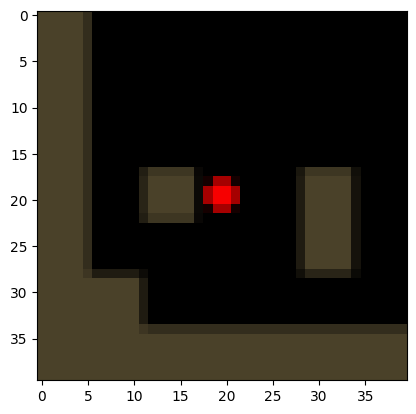

In [ ]:
#| hide
import matplotlib.pyplot as plt
def unnormalize(img):
    # img: tensor C×H×W
    img = img.clone()
    img = img * 0.5 + 0.5  # reverse Normalize((0.5),(0.5))
    return img
img = unnormalize(img)
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
#| hide
migs = dataset[9]  # get first item

Getting data at index 9


<matplotlib.image.AxesImage>

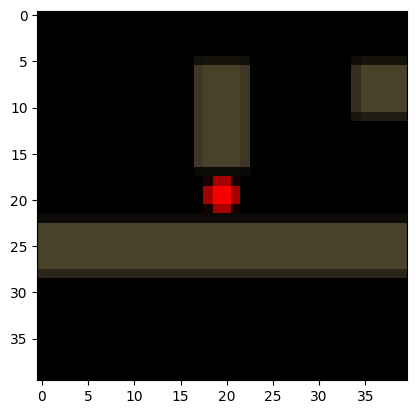

In [ ]:
#| hide
import matplotlib.pyplot as plt
plt.imshow(np.transpose(migs[0].numpy(), (1, 2, 0)))


## Sequence Dataset

In [ ]:
#| export
class RolloutSequenceDataset(_RolloutDataset): # pylint: disable=too-few-public-methods
    """ Encapsulates rollouts.

    Rollouts should be stored in subdirs of the root directory, in the form of npz files,
    each containing a dictionary with the keys:
        - observations: (rollout_len, *obs_shape)
        - actions: (rovllout_len, action_size)
        - rewards: (rollout_len,)
        - terminals: (rollout_len,), boolean

     As the dataset is too big to be entirely stored in rams, only chunks of it
     are stored, consisting of a constant number of files (determined by the
     buffer_size parameter).  Once built, buffers must be loaded with the
     load_next_buffer method.

    Data are then provided in the form of tuples (obs, action, reward, terminal, next_obs):
    - obs: (seq_len, *obs_shape)
    - actions: (seq_len, action_size)
    - reward: (seq_len,)
    - terminal: (seq_len,) boolean
    - next_obs: (seq_len, *obs_shape)

    NOTE: seq_len < rollout_len in moste use cases

    :args root: root directory of data sequences
    :args seq_len: number of timesteps extracted from each rollout
    :args transform: transformation of the observations
    :args train: if True, train data, else test
    """
    def __init__(self, agent, root, seq_len, transform, buffer_size=200, train=True, obs_key='pov'): # pylint: disable=too-many-arguments
        super().__init__(agent, root, transform, buffer_size, train, obs_key)
        self._seq_len = seq_len
        self.agent = agent
         
    def __getitem__(self, i):
        file_index = bisect(self._cum_size, i) - 1
        seq_index = i - self._cum_size[file_index]
        data = self._buffer[file_index]
        
        # Ensure we don't go past the episode boundary
        episode_len = data['episode_len'].item()
        max_start = episode_len - self._seq_len - 1
        
        if seq_index > max_start:
            # This shouldn't happen if __len__ is correct
            # But as a safety, clamp it
            seq_index = max(0, max_start)
        
        return {**self._get_data(data, seq_index), 'index': i}
    
    def _get_agent_data(self, data, seq_index):
        data_dict = {}
        
        # Get obs[t] and obs[t+1] for t in [seq_index, seq_index+seq_len)
        obs_data = data[f'{self.agent}_obs'][seq_index:seq_index + self._seq_len + 1]
        
        # Transform observations
        obs_transformed = [self._transform(obs_data[i][self.obs_key].astype(np.uint8)) 
                        for i in range(len(obs_data))]
        
        # obs[t] and next_obs[t] = obs[t+1]
        obs = obs_transformed[:-1]        # length: seq_len
        next_obs = obs_transformed[1:]    # length: seq_len
        
        # Get actions, rewards, info that correspond to transitions
        # action[t] is the action taken at obs[t] leading to next_obs[t]
        action = data[f'{self.agent}_act'][seq_index:seq_index + self._seq_len]
        reward = data[f'{self.agent}_rew'][seq_index:seq_index + self._seq_len]
        info = data[f'{self.agent}_info'][seq_index:seq_index + self._seq_len]
        
        # Stack obs into tensors for easier collation
        data_dict["obs"] = torch.stack(obs)           # (seq_len, C, H, W)
        data_dict["next_obs"] = torch.stack(next_obs) # (seq_len, C, H, W)
        data_dict["act"] = torch.from_numpy(action.astype(np.float32))  # (seq_len, action_dim)
        data_dict["rew"] = torch.from_numpy(reward.astype(np.float32))  # (seq_len,)
        data_dict["info"] = info  # Keep as is or remove if not needed
        
        return data_dict

    def _get_data(self, data, seq_index):
        return self._get_agent_data(data, seq_index)

    def _data_per_sequence(self, data_length):
        return data_length - self._seq_len


In [ ]:
#| hide
from MAWM.data.utils import transform_train, transform_test
from torchvision import transforms
import numpy as np

ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE =\
    3, 32, 256, 32, 40

tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((40, 40)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

dataset = RolloutSequenceDataset(
    agent='agent_0',
    root='../marl_grid_data/',
    transform=tf,
    train=True,
    seq_len=50,
    buffer_size=10
)

In [ ]:
#| hide
import torch

def custom_collate(batch):
    """Collate batch of dicts containing tensors"""
    batch_dict = {}
    
    for key in batch[0].keys():
        if key == 'info':
            # Keep info as list (don't collate objects)
            batch_dict[key] = torch.stack([item[key] for item in batch]).flatten(0, 1)
        else:
            # Stack tensors along batch dimension
            batch_dict[key] = torch.stack([item[key] for item in batch])
    
    return batch_dict

def flatten_sequence_collate(batch):
    """Collate and flatten sequences into individual frames"""
    batch_dict = {}
    
    for key in batch[0].keys():
        if key == 'info':
            batch_dict[key] = np.stack([item[key] for item in batch]).reshape(-1)
        else:
            # Stack along batch dimension: (batch_size, seq_len, ...)
            stacked = torch.stack([item[key] for item in batch])
            
            # Flatten batch and seq_len: (batch_size * seq_len, ...)
            batch_dict[key] = stacked.flatten(0, 1)
    
    return batch_dict


train_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=0,
    collate_fn=flatten_sequence_collate
)

Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
# #| hide
# train_loader.dataset.load_next_buffer()

In [ ]:
# train_loader = torch.utils.data.DataLoader(
#         dataset, batch_size=32, shuffle=True, num_workers=0)


Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
# #| hide
# for batch in train_loader:
#     print(batch.keys())
#     break

dict_keys(['obs', 'next_obs', 'act', 'rew', 'info'])


In [ ]:
# #| hide
# batch['obs'].shape, batch['next_obs'].shape, batch['act'].shape, batch['rew'].shape, batch['info'].shape   


(torch.Size([1600, 3, 40, 40]),
 torch.Size([1600, 3, 40, 40]),
 torch.Size([1600]),
 torch.Size([1600]),
 (1600,))

In [ ]:
# #| hide
# batch['info'][1599]

{'done': True,
 'comm': 0,
 'nonadv_done': False,
 'posd': array([6, 5, 1]),
 'sees_goal': 1,
 'comm_str': ''}

In [ ]:
# #| hide
# batch_data = dataset[0]
# batch_data.keys()

dict_keys(['obs', 'next_obs', 'act', 'rew', 'info'])

## Lejepa vision dataset


In [ ]:
#| export
import torch
class LejepaVisionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform, V=1):
        self.V = V
        self.ds = dataset
        self.tf = transform

    def __getitem__(self, i):
        img, done, agent = self.ds[i]
        return torch.stack([self.tf(img) for _ in range(self.V)]), done, agent

    def __len__(self):
        return len(self.ds)

## CV2 Trials

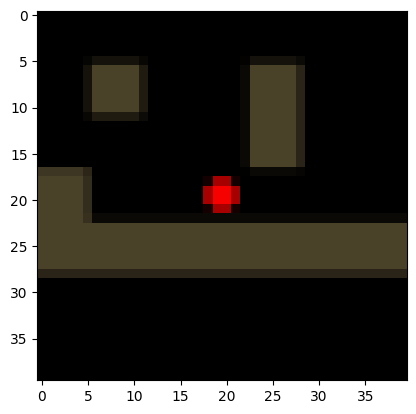

In [ ]:
# import matplotlib.pyplot as plt
# def unnormalize(img):
#     # img: tensor C×H×W
#     img = img.clone()
#     img = img * 0.5 + 0.5  # reverse Normalize((0.5),(0.5))
#     return img
# img = dataset[20][0]
# img = unnormalize(img)
# plt.imshow(img.permute(1, 2, 0).numpy())
# plt.show()

In [ ]:
# img.permute(1, 2, 0).dtype

torch.float32

In [ ]:
# # parse the image using cv2 detectors
# import cv2
# img_cv2 = img.permute(1, 2, 0).numpy()
# img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_RGB2BGR)
# cv2.imshow('Image', img_cv2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_RGB2BGR)

In [ ]:
# type(img_cv2)

numpy.ndarray

In [ ]:
# save the img_

[ WARN:0@1560.655] global loadsave.cpp:1063 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


True

### OpenCV

In [ ]:
# import cv2
# gray = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY)

# # mask = cv2.inRange(hsv, lower_color, upper_color)
# # gray = cv2.cvtColor(img.permute(1, 2, 0).numpy().astype(np.uint8), cv2.COLOR_BGR2GRAY)
# _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)


In [ ]:
# import cv2
# import numpy as np

# img = cv2.imread("../mains/agent_0_step_0.png")  # Load your image here
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

# contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# primitives = []

# for cnt in contours:
#     epsilon = 0.02 * cv2.arcLength(cnt, True)
#     approx = cv2.approxPolyDP(cnt, epsilon, True)

#     if len(approx) == 4:
#         x, y, w, h = cv2.boundingRect(approx)
#         ar = w / h

#         shape = "square" if abs(ar - 1.0) < 0.1 else "rectangle"
#         primitives.append((shape, x, y, w, h))


In [ ]:
# primitives

[('rectangle', 0, 30, 6, 12),
 ('rectangle', 12, 6, 18, 6),
 ('square', 36, 0, 6, 6)]

In [ ]:
# import cv2
# import numpy as np
# def get_graphics_primitives(img_np):
#     img = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
#     pixels = img.reshape(-1, 3)
#     colors = np.unique(pixels, axis=0)

#     primitives = []
#     background_color = np.array([0, 0, 0])  # assuming black background
#     for color in colors:
#         if np.all(color == background_color):
#             continue

#         mask = cv2.inRange(img, color, color)
#         contours, _ = cv2.findContours(
#             mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
#         )

#         for cnt in contours:
#             x, y, w, h = cv2.boundingRect(cnt)
#             primitives.append((color, x, y, w, h))
            
#     return primitives
    


In [ ]:
# img = cv2.imread("../mains/agent_0_step_0.png") 
# inp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# primitives = get_graphics_primitives(inp)
# primitives

[(array([ 0,  0, 28], dtype=uint8), 22, 22, 1, 1),
 (array([ 0,  0, 28], dtype=uint8), 19, 22, 1, 1),
 (array([ 0,  0, 28], dtype=uint8), 22, 19, 1, 1),
 (array([ 0,  0, 28], dtype=uint8), 19, 19, 1, 1),
 (array([  0,   0, 198], dtype=uint8), 19, 19, 4, 4),
 (array([  0,   0, 255], dtype=uint8), 20, 20, 2, 2),
 (array([  0, 255,   0], dtype=uint8), 24, 36, 6, 6),
 (array([28,  0,  0], dtype=uint8), 34, 10, 1, 1),
 (array([28,  0,  0], dtype=uint8), 31, 10, 1, 1),
 (array([28,  0,  0], dtype=uint8), 34, 7, 1, 1),
 (array([28,  0,  0], dtype=uint8), 31, 7, 1, 1),
 (array([42, 65, 74], dtype=uint8), 30, 30, 6, 6),
 (array([42, 65, 74], dtype=uint8), 12, 30, 12, 12),
 (array([42, 65, 74], dtype=uint8), 0, 30, 6, 12),
 (array([42, 65, 74], dtype=uint8), 12, 6, 18, 6),
 (array([42, 65, 74], dtype=uint8), 36, 0, 6, 6),
 (array([198,   0,   0], dtype=uint8), 31, 7, 4, 4),
 (array([255,   0,   0], dtype=uint8), 32, 8, 2, 2)]

In [ ]:
# import cv2, numpy as np
# img = cv2.imread("../mains/agent_0_step_0.png")
# pixels = img.reshape(-1, 3)
# colors = np.unique(pixels, axis=0)


In [ ]:
# primitives = []
# background_color = np.array([0, 0, 0])  # assuming black background
# for color in colors:
#     if np.all(color == background_color):
#         continue

#     mask = cv2.inRange(img, color, color)
#     contours, _ = cv2.findContours(
#         mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
#     )

#     for cnt in contours:
#         x, y, w, h = cv2.boundingRect(cnt)
#         primitives.append((color, x, y, w, h))


In [ ]:
# primitives, primitives.__len__()

([(array([ 0,  0, 28], dtype=uint8), 22, 22, 1, 1),
  (array([ 0,  0, 28], dtype=uint8), 19, 22, 1, 1),
  (array([ 0,  0, 28], dtype=uint8), 22, 19, 1, 1),
  (array([ 0,  0, 28], dtype=uint8), 19, 19, 1, 1),
  (array([  0,   0, 198], dtype=uint8), 19, 19, 4, 4),
  (array([  0,   0, 255], dtype=uint8), 20, 20, 2, 2),
  (array([  0, 255,   0], dtype=uint8), 24, 36, 6, 6),
  (array([28,  0,  0], dtype=uint8), 34, 10, 1, 1),
  (array([28,  0,  0], dtype=uint8), 31, 10, 1, 1),
  (array([28,  0,  0], dtype=uint8), 34, 7, 1, 1),
  (array([28,  0,  0], dtype=uint8), 31, 7, 1, 1),
  (array([42, 65, 74], dtype=uint8), 30, 30, 6, 6),
  (array([42, 65, 74], dtype=uint8), 12, 30, 12, 12),
  (array([42, 65, 74], dtype=uint8), 0, 30, 6, 12),
  (array([42, 65, 74], dtype=uint8), 12, 6, 18, 6),
  (array([42, 65, 74], dtype=uint8), 36, 0, 6, 6),
  (array([198,   0,   0], dtype=uint8), 31, 7, 4, 4),
  (array([255,   0,   0], dtype=uint8), 32, 8, 2, 2)],
 18)

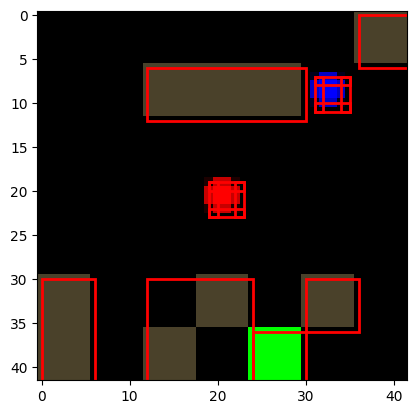

In [ ]:
# #draw bounding boxes to the location of the primitives
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1)
# ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# for primitive in primitives:
#     color, x1, y1, w, h = primitive
#     x2, y2 = x1 + w, y1 + h
    
#     # Draw rectangle
#     ax.add_patch(plt.Rectangle((x1, y1), w, h, edgecolor='r', facecolor='none', linewidth=2))
#     rgb_color = (color[2]/255, color[1]/255, color[0]/255)
#     # ax.plot((x1, x2), (y1, y2), '-r', linewidth=2)
    

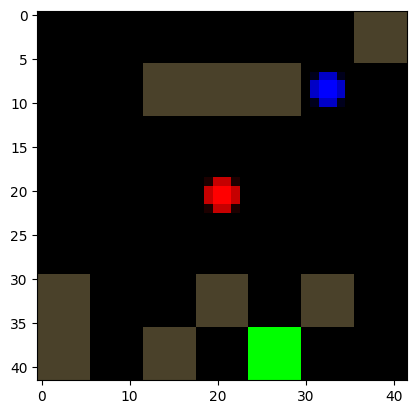

In [ ]:
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()

In [ ]:
# def show_grid(img, GRID = 7, CELL = 6):
#     import cv2
#     import matplotlib.pyplot as plt
#     if not CELL:
#         CELL = img.shape[0] // GRID
    
#     vis = img.copy()
#     vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
#     for i in range(1, GRID):
#         cv2.line(vis, (i*CELL, 0), (i*CELL, 42), (255,255,255), 1)
#         cv2.line(vis, (0, i*CELL), (42, i*CELL), (255,255,255), 1)
#     plt.imshow(vis, interpolation="nearest")
#     plt.axis("off")

#     return vis


array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [74, 65, 42],
        [74, 65, 42],
        [74, 65, 42]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [74, 65, 42],
        [74, 65, 42],
        [74, 65, 42]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [74, 65, 42],
        [74, 65, 42],
        [74, 65, 42]],

       ...,

       [[74, 65, 42],
        [74, 65, 42],
        [74, 65, 42],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[74, 65, 42],
        [74, 65, 42],
        [74, 65, 42],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[74, 65, 42],
        [74, 65, 42],
        [74, 65, 42],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

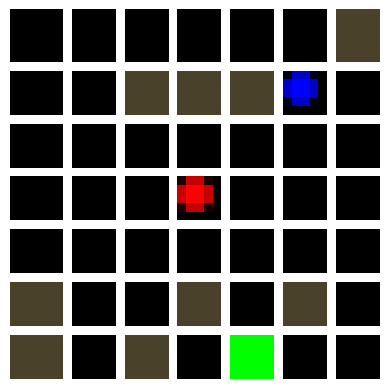

In [ ]:
# show_grid(img)

In [ ]:
# img.shape

(42, 42, 3)

In [ ]:
# GRID = 7
# CELL = 6  # 42 / 7

# cells = [
#     [cv2.cvtColor(img, cv2.COLOR_BGR2RGB)[j*CELL:(j+1)*CELL, i*CELL:(i+1)*CELL]
#      for i in range(GRID)]
#     for j in range(GRID)
# ]


(-0.5, 41.5, 41.5, -0.5)

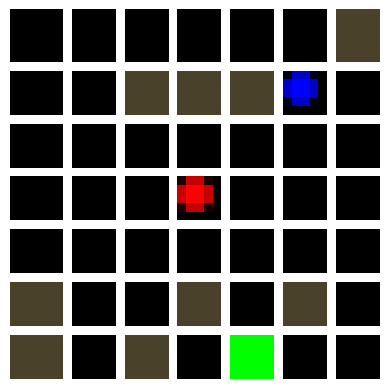

In [ ]:
# vis = img.copy()
# vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
# for i in range(1, GRID):
#     cv2.line(vis, (i*CELL, 0), (i*CELL, 42), (255,255,255), 1)
#     cv2.line(vis, (0, i*CELL), (42, i*CELL), (255,255,255), 1)

# plt.imshow(vis, interpolation="nearest")
# plt.axis("off")


In [ ]:
# color_map = {
#     (0, 0, 198): "Blue Agent",
#     (0, 0, 255): "Blue Agent",
#     (0, 255, 0): "Goal",
#     (74, 65, 42): "Wall",
#     (198, 0, 0): "Red Agent",
#     (255, 0, 0): "Red Agent",
#     (28, 0, 0): "Red Agent",
#     (0, 0, 0): "Empty"
# }


# def get_cell_color(cell):
#     np_to_tuple = lambda arr: tuple(int(x) for x in arr)
#     pixels = cell.reshape(-1, 3)
#     colors, counts = np.unique(pixels, axis=0, return_counts=True)
#     # print(colors, len(colors), "+++++")
#     # color = colors[np.argmax(counts)]
#     if len(colors) == 1:
#         if np_to_tuple(colors[0]) in [(0, 255, 0)]:
#             return "G" #"Goal"
#         elif np_to_tuple(colors[0]) in [(74, 65, 42)]:
#             return "W" #"Wall"
#         else:
#             return "E" #"Empty"
        
#     else:
        
#         for color in colors:
#             if np_to_tuple(color) in [(198, 0, 0), (28, 0, 0), (255, 0, 0)]:
#                 color = (255, 0, 0)
#                 return "R" #"RedAgent"
#             elif np_to_tuple(color) in [(0, 0, 198), (0, 0, 255)]:
#                 color = (0, 0, 255)
#                 return "B" #"BlueAgent"
                
    

In [ ]:
# def get_grid_chars(img, GRID=7, CELL=6): 
#     cells = [[cv2.cvtColor(img, cv2.COLOR_BGR2RGB)[j*CELL:(j+1)*CELL, i*CELL:(i+1)*CELL]
#               for i in range(GRID)]
#               for j in range(GRID)
#             ]
    
#     grid = np.zeros((GRID,GRID), dtype=object)
#     for r in range(GRID):
#         for c in range(GRID):
#             color = get_cell_color(cells[r][c])
#             grid[r][c] = color
#     return grid

In [ ]:
# grid = get_grid_chars(img)
# grid

array([['E', 'E', 'E', 'E', 'E', 'E', 'W'],
       ['E', 'E', 'W', 'W', 'W', 'B', 'E'],
       ['E', 'E', 'E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'R', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E', 'E', 'E'],
       ['W', 'E', 'E', 'W', 'E', 'W', 'E'],
       ['W', 'E', 'W', 'E', 'G', 'E', 'E']], dtype=object)

In [ ]:
# # grid = [["" for _ in range(7)] for _ in range(7)]
# grid = np.zeros((7,7), dtype=object)
# for r in range(7):
#     for c in range(7):
#         color = get_cell_color(cells[r][c])
#         grid[r][c] = color
        

In [ ]:
# grid

array([['E', 'E', 'E', 'E', 'E', 'E', 'W'],
       ['E', 'E', 'W', 'W', 'W', 'B', 'E'],
       ['E', 'E', 'E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'R', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E', 'E', 'E'],
       ['W', 'E', 'E', 'W', 'E', 'W', 'E'],
       ['W', 'E', 'W', 'E', 'G', 'E', 'E']], dtype=object)

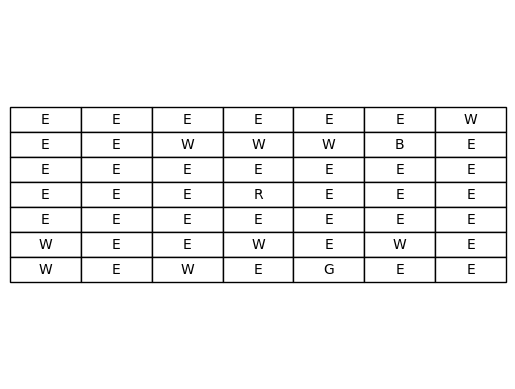

In [ ]:
# # plot the grid using matplotlib
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# ax.axis('tight')
# ax.axis('off')
# table = ax.table(cellText=grid, loc='center', cellLoc='center')
# table.scale(1, 1.5)
# plt.show()

### Other


--- Detected Drawing Commands (Primitives) ---
Agent: Bounding Box=(19, 19, 5, 5), Center=(21, 21)
Obstacle 1: Bounding Box=(5, 35, 11, 5)
Obstacle 2: Bounding Box=(10, 5, 6, 8)
Obstacle 3: Bounding Box=(35, 0, 5, 36)


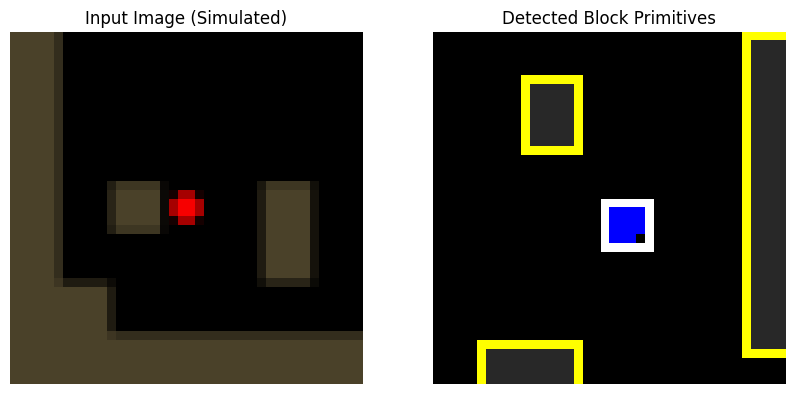

In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# def parse_grid_primitives_final(input_image_array):
#     """
#     Detects blocky primitives (agent and obstacles) in a grid-like image 
#     using color thresholding and contour detection with refined parameters.
#     """
#     # 1. Input Validation and Preparation
#     if input_image_array is None or input_image_array.size == 0:
#         print("Error: Input array is empty or None.")
#         return [] , None
    
#     img_bgr = input_image_array.astype(np.uint8)
#     output_img = img_bgr.copy()
#     primitives = []
    
#     # Check if the array is mostly black (debug check)
#     if np.all(img_bgr <= 1):
#         print("Warning: The input array appears to be all black. Please ensure the correct array is being passed.")
#         return [], img_bgr

#     # --- Threshold Definitions (Based on visible colors in the image) ---
#     # We will use BGR for simplicity since the colors are blocky and distinct.

#     # 2. Agent (Pure Blue)
#     # Target: BGR = [255, 0, 0]. We use a tight range around the blue channel.
#     agent_lower = np.array([200, 0, 0])
#     agent_upper = np.array([255, 50, 50]) # Allow small variation in G/R

#     # 3. Obstacles (Dark Brown/Gray)
#     # Target: BGR approx [40, 40, 40]. Low values across all channels.
#     obstacle_lower = np.array([30, 30, 30])
#     obstacle_upper = np.array([70, 70, 70]) # A small, safe range for the brown blocks

#     # =======================================================
#     # DETECTION
#     # =======================================================

#     # --- PRIMITIVE DETECTION (AGENT - Blue) ---
#     agent_mask = cv2.inRange(img_bgr, agent_lower, agent_upper)
#     agent_contours, _ = cv2.findContours(agent_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     if agent_contours:
#         largest_agent_contour = max(agent_contours, key=cv2.contourArea)
#         x, y, w, h = cv2.boundingRect(largest_agent_contour)
        
#         primitives.append(f"Agent: Bounding Box=({x}, {y}, {w}, {h}), Center=({x + w//2}, {y + h//2})")
#         cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 255, 255), 1) # White outline
        
#     # --- PRIMITIVE DETECTION (OBSTACLES - Brown) ---
#     obstacle_mask = cv2.inRange(img_bgr, obstacle_lower, obstacle_upper)
    
#     # Filter out the black background which might be included if the lower bound is 0
#     # Also filter out the grid boundary lines from the plot if they are dark.
#     min_area = 5 
    
#     obstacle_contours, _ = cv2.findContours(obstacle_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     for i, contour in enumerate(obstacle_contours):
#         if cv2.contourArea(contour) > min_area:
#             x, y, w, h = cv2.boundingRect(contour)
            
#             # Filter out the outer black frame if it was picked up
#             if x == 0 and y == 0 and w == img_bgr.shape[1] and h == img_bgr.shape[0]:
#                 continue
            
#             primitives.append(f"Obstacle {i+1}: Bounding Box=({x}, {y}, {w}, {h})")
#             cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 255, 255), 1) # Yellow outline

#     return primitives, output_img

# # --- EXAMPLE USAGE ---
# if __name__ == '__main__':
    
#     # ----------------------------------------------------------------------------------
#     # ** IMPORTANT **: You must insert your actual, correct NumPy array here.
#     # The array MUST contain the color information for blue and brown.
#     # ----------------------------------------------------------------------------------
    
#     # Dummy creation of the image for testing the script's logic
#     # Creates a 40x40 grid that roughly mimics your image's colors
#     H, W = 40, 40
#     dummy_image = img_cv2#img.permute(1, 2, 0).numpy()#np.zeros((H, W, 3), dtype=np.uint8) 
    
#     # Draw Obstacles (Dark Brown/Gray BGR [40, 40, 40])
#     obstacle_color = [40, 40, 40]
#     cv2.rectangle(dummy_image, (10, 5), (15, 12), obstacle_color, -1) # Top-left block
#     cv2.rectangle(dummy_image, (35, 0), (40, 35), obstacle_color, -1) # Right wall
#     cv2.rectangle(dummy_image, (5, 35), (15, 40), obstacle_color, -1) # Bottom-left block
    
#     # Draw Agent (Blue BGR [255, 0, 0]) - A small cross shape
#     agent_color = [255, 0, 0]
#     cv2.rectangle(dummy_image, (19, 20), (22, 23), agent_color, -1) 
#     cv2.rectangle(dummy_image, (20, 19), (23, 22), agent_color, -1) 
    
#     input_image_array = dummy_image 
    
#     # 3. Run the parser
#     detected_commands, output_image = parse_grid_primitives_final(input_image_array)
    
#     print("\n--- Detected Drawing Commands (Primitives) ---")
#     if detected_commands:
#         for command in detected_commands:
#             print(command)
#     else:
#         print("No primitives detected with the current color parameters.")

#     # 4. Display the results
#     if output_image is not None:
#         output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
        
#         plt.figure(figsize=(10, 5))
#         plt.subplot(1, 2, 1)
#         # plt.imshow(cv2.cvtColor(input_image_array, cv2.COLOR_BGR2RGB))
#         plt.imshow(img.permute(1, 2, 0).numpy())
#         plt.title('Input Image (Simulated)')
#         plt.axis('off')
        
#         plt.subplot(1, 2, 2)
#         plt.imshow(output_image_rgb)
#         plt.title('Detected Block Primitives')
#         plt.axis('off')
#         plt.savefig('detected_primitives.png')
#         plt.show()


--- Detected Drawing Commands (Primitives) ---
Agent: Bounding Box=(19, 19, 5, 5), Center=(21, 21)
Obstacle 1: Bounding Box=(6, 36, 11, 4)
Obstacle 2: Bounding Box=(11, 6, 6, 8)
Obstacle 3: Bounding Box=(36, 0, 4, 37)


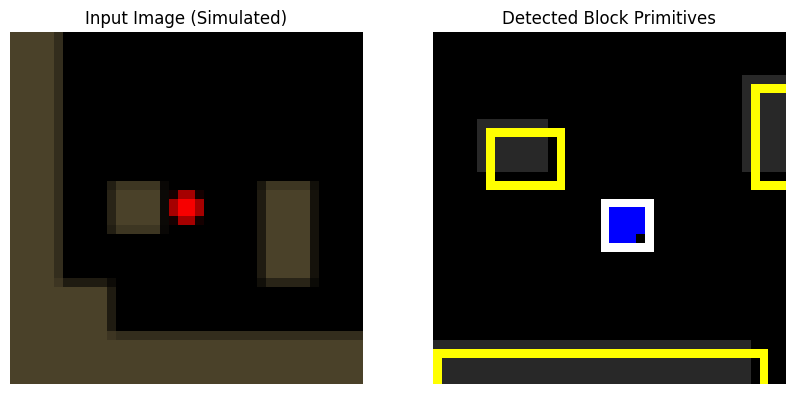

In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# def parse_grid_primitives_final_v2(input_image_array):
#     """
#     Detects blocky primitives (agent and obstacles) in a grid-like image 
#     using color thresholding and contour detection with refined, tighter parameters.
#     """
#     # 1. Input Validation and Preparation
#     if input_image_array is None or input_image_array.size == 0:
#         print("Error: Input array is empty or None.")
#         return [], None
    
#     img_bgr = input_image_array.astype(np.uint8)
#     output_img = img_bgr.copy()
#     primitives = []
    
#     # Check if the array is mostly black (debug check)
#     if np.all(img_bgr <= 1):
#         print("Warning: The input array appears to be all black. Please ensure the correct array is being passed.")
#         return [], img_bgr

#     # --- Threshold Definitions (TIGHTENED for specific colors) ---
    
#     # 2. Agent (Pure Blue) - Targeting the visible blue cross
#     # Agent BGR: B=[255], G=[0], R=[0]. (Tolerating very little noise)
#     agent_lower = np.array([200, 0, 0])
#     agent_upper = np.array([255, 30, 30]) # Allowing B channel to be high, G/R low.

#     # 3. Obstacles (Dark Brown/Gray) - Targeting the true obstacles, excluding light noise.
#     # The brown obstacles are around BGR [40, 40, 40]. The teal/dark noise is darker.
#     obstacle_lower = np.array([30, 30, 30])
#     obstacle_upper = np.array([75, 75, 75]) # Increased upper limit slightly to capture varied dark brown.

#     # =======================================================
#     # DETECTION
#     # =======================================================

#     # --- PRIMITIVE DETECTION (AGENT - Blue) ---
#     agent_mask = cv2.inRange(img_bgr, agent_lower, agent_upper)
#     agent_contours, _ = cv2.findContours(agent_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     if agent_contours:
#         largest_agent_contour = max(agent_contours, key=cv2.contourArea)
#         x, y, w, h = cv2.boundingRect(largest_agent_contour)
        
#         # Filter for the agent: require a reasonable size (e.g., minimum 10 pixels area)
#         if w * h > 5: 
#             primitives.append(f"Agent: Bounding Box=({x}, {y}, {w}, {h}), Center=({x + w//2}, {y + h//2})")
#             cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 255, 255), 1) # White outline
        
#     # --- PRIMITIVE DETECTION (OBSTACLES - Brown) ---
#     obstacle_mask = cv2.inRange(img_bgr, obstacle_lower, obstacle_upper)
    
#     # Use a morphological operation (opening) to remove small noise dots before finding contours
#     kernel = np.ones((2, 2), np.uint8)
#     obstacle_mask = cv2.morphologyEx(obstacle_mask, cv2.MORPH_OPEN, kernel)
    
#     obstacle_contours, _ = cv2.findContours(obstacle_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     # Filter parameters
#     min_area = 10 # Minimum area for an obstacle
    
#     for i, contour in enumerate(obstacle_contours):
#         area = cv2.contourArea(contour)
#         if area > min_area:
#             x, y, w, h = cv2.boundingRect(contour)
            
#             # Additional check: Filter out very wide/tall contours that may be axes or plot borders
#             if w > 20 and h > 20: # Example check to avoid tiny or huge elements
#                 pass
            
#             primitives.append(f"Obstacle {i+1}: Bounding Box=({x}, {y}, {w}, {h})")
#             cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 255, 255), 1) # Yellow outline

#     return primitives, output_img

# # --- EXAMPLE USAGE (Use your actual NumPy array here) ---
# if __name__ == '__main__':
    
#     # ----------------------------------------------------------------------------------
#     # ** IMPORTANT **: You must insert your actual, correct NumPy array here.
#     # If using the provided image, you must load it into a NumPy array first.
#     # For demonstration, I am loading the image that was uploaded.
#     # ----------------------------------------------------------------------------------
    
#     # Load the image from the URL provided (Placeholder for the actual array loading)
#     # In a typical script, you would replace this with your environment's array
#     try:
#         # Assuming the image is saved locally as 'agent_1_obs_step_14.png'
#         input_image_array = img_cv2#cv2.imread('agent_1_obs_step_14.png') 
#         # If the image loads correctly, you'd use it. Otherwise, use a placeholder.
#         if input_image_array is None:
#              raise FileNotFoundError
#     except:
#         # FALLBACK: Create a black array if the file path is wrong
#         print("Warning: Using placeholder black image. Please ensure your actual NumPy array is loaded here.")
#         input_image_array = np.zeros((40, 40, 3), dtype=np.uint8)

#     # 3. Run the parser
#     detected_commands, output_image = parse_grid_primitives_final_v2(input_image_array)
    
#     print("\n--- Detected Drawing Commands (Primitives) ---")
#     if detected_commands:
#         for command in detected_commands:
#             print(command)
#     else:
#         print("No primitives detected with the current color parameters.")

#     # 4. Display the results
#     if output_image is not None:
#         output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
        
#         plt.figure(figsize=(10, 5))
#         plt.subplot(1, 2, 1)
#         # plt.imshow(cv2.cvtColor(input_image_array, cv2.COLOR_BGR2RGB))
#         plt.imshow(img.permute(1, 2, 0).numpy())
#         plt.title('Input Image (Simulated)')
#         plt.axis('off')
        
#         plt.subplot(1, 2, 2)
#         plt.imshow(torch.tensor(output_image_rgb).permute(1, 0, 2).numpy())
#         plt.title('Detected Block Primitives')
#         plt.axis('off')
#         plt.savefig('detected_primitives.png')
#         plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].



--- Detected Drawing Commands (Primitives) ---
No primitives detected with the current color parameters.


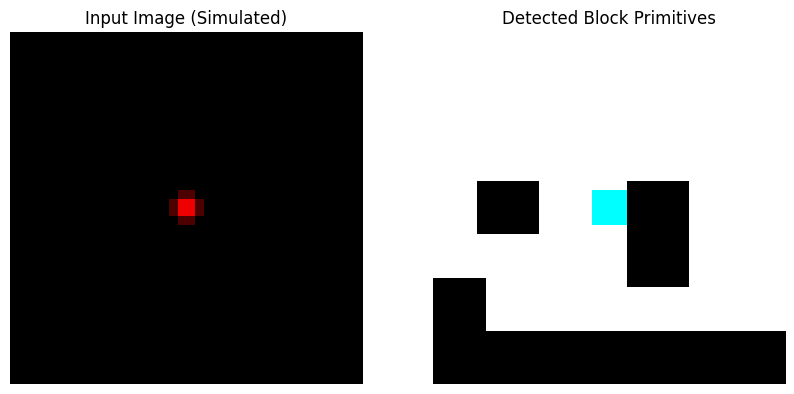

In [ ]:
# import cv2
# import numpy as np

# def parse_grid_primitives_final_v3(input_image_array):
#     """
#     Detects blocky primitives with updated BGR thresholds to match the new 
#     input array where the agent is RED.
#     """
#     # ... (Input Validation and Preparation remains the same)
#     if input_image_array is None or input_image_array.size == 0:
#         print("Error: Input array is empty or None.")
#         return [], None
    
#     img_bgr = input_image_array.astype(np.uint8)
#     output_img = img_bgr.copy()
#     primitives = []
    
#     if np.all(img_bgr <= 1):
#         print("Warning: The input array appears to be all black.")
#         return [], img_bgr

#     # --- Threshold Definitions (ADJUSTED FOR RED AGENT) ---
    
#     # 2. Agent (RED) - Targeting the red dot. BGR: B=0, G=0, R=255
#     # The B and G channels must be low, and the R channel must be high.
#     agent_lower = np.array([0, 0, 200]) # B, G near zero, R high
#     agent_upper = np.array([30, 30, 255]) # Tolerating slight variation in B/G

#     # 3. Obstacles (Dark Brown/Gray/Teal) - Keeping the same robust range
#     # Target: BGR approx [30-75, 30-75, 30-75]
#     obstacle_lower = np.array([30, 30, 30])
#     obstacle_upper = np.array([75, 75, 75]) 

#     # =======================================================
#     # DETECTION (Logic remains the same)
#     # =======================================================

#     # --- PRIMITIVE DETECTION (AGENT - RED) ---
#     agent_mask = cv2.inRange(img_bgr, agent_lower, agent_upper)
#     agent_contours, _ = cv2.findContours(agent_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     if agent_contours:
#         largest_agent_contour = max(agent_contours, key=cv2.contourArea)
#         x, y, w, h = cv2.boundingRect(largest_agent_contour)
        
#         if w * h > 5: 
#             primitives.append(f"Agent: Bounding Box=({x}, {y}, {w}, {h}), Center=({x + w//2}, {y + h//2})")
#             cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 255, 255), 1) # White outline
        
#     # --- PRIMITIVE DETECTION (OBSTACLES) ---
#     obstacle_mask = cv2.inRange(img_bgr, obstacle_lower, obstacle_upper)
    
#     kernel = np.ones((2, 2), np.uint8)
#     obstacle_mask = cv2.morphologyEx(obstacle_mask, cv2.MORPH_OPEN, kernel)
    
#     obstacle_contours, _ = cv2.findContours(obstacle_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     min_area = 10 
    
#     for i, contour in enumerate(obstacle_contours):
#         area = cv2.contourArea(contour)
#         if area > min_area:
#             x, y, w, h = cv2.boundingRect(contour)
            
#             # Simple check to avoid very small noise
#             if w < 3 or h < 3: 
#                  continue
            
#             primitives.append(f"Obstacle {i+1}: Bounding Box=({x}, {y}, {w}, {h})")
#             cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 255, 255), 1) # Yellow outline

#     return primitives, output_img

# # --- Final Recommendation ---
# # 1. Use the full, original 40x40 environment NumPy array.
# # 2. Use the parse_grid_primitives_final_v3 function.


# # --- EXAMPLE USAGE (Use your actual NumPy array here) ---
# if __name__ == '__main__':
    
#     # ----------------------------------------------------------------------------------
#     # ** IMPORTANT **: You must insert your actual, correct NumPy array here.
#     # If using the provided image, you must load it into a NumPy array first.
#     # For demonstration, I am loading the image that was uploaded.
#     # ----------------------------------------------------------------------------------
    
#     # Load the image from the URL provided (Placeholder for the actual array loading)
#     # In a typical script, you would replace this with your environment's array
#     try:
#         # Assuming the image is saved locally as 'agent_1_obs_step_14.png'
#         img = dataset[1][0]
#         img_cv2 = cv2.cvtColor(img.permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR)
#         input_image_array = img_cv2#cv2.imread('agent_1_obs_step_14.png') 
#         # If the image loads correctly, you'd use it. Otherwise, use a placeholder.
#         if input_image_array is None:
#              raise FileNotFoundError
#     except:
#         # FALLBACK: Create a black array if the file path is wrong
#         print("Warning: Using placeholder black image. Please ensure your actual NumPy array is loaded here.")
#         input_image_array = np.zeros((40, 40, 3), dtype=np.uint8)

#     # 3. Run the parser
#     detected_commands, output_image = parse_grid_primitives_final_v3(input_image_array)
    
#     print("\n--- Detected Drawing Commands (Primitives) ---")
#     if detected_commands:
#         for command in detected_commands:
#             print(command)
#     else:
#         print("No primitives detected with the current color parameters.")

#     # 4. Display the results
#     if output_image is not None:
#         output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
        
#         plt.figure(figsize=(10, 5))
#         plt.subplot(1, 2, 1)
#         # plt.imshow(cv2.cvtColor(input_image_array, cv2.COLOR_BGR2RGB))
#         plt.imshow(img.permute(1, 2, 0).numpy())
#         plt.title('Input Image (Simulated)')
#         plt.axis('off')
        
#         plt.subplot(1, 2, 2)
#         plt.imshow(output_image_rgb)
#         plt.title('Detected Block Primitives')
#         plt.axis('off')
#         plt.savefig('detected_primitives.png')
#         plt.show()

In [ ]:
# img.shape, img_cv2.shape

(torch.Size([3, 40, 40]), (40, 40, 3))

### SKimage

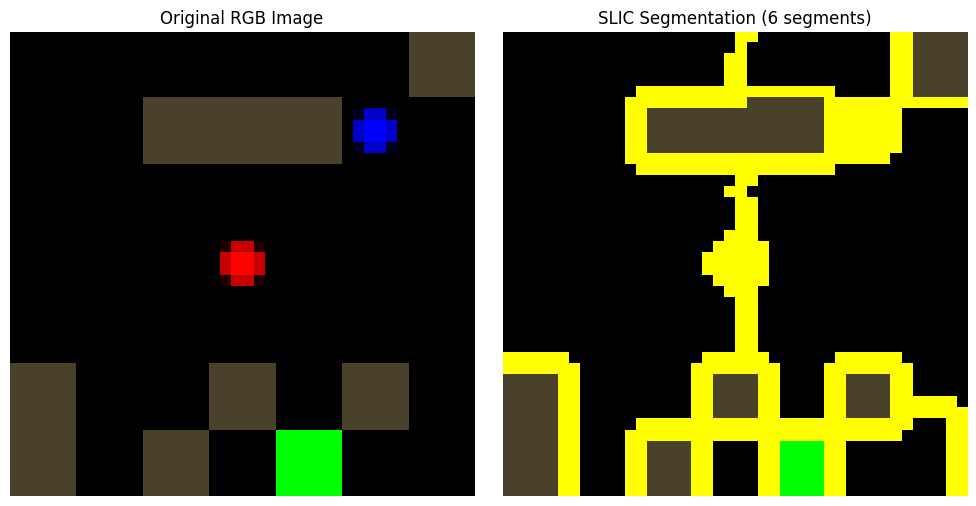

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.segmentation import slic, mark_boundaries
from skimage.segmentation import quickshift
from skimage.util import img_as_float
# Replace 'your_rgb_image.jpg' with the actual path to your image
image = io.imread('../mains/agent_0_step_0.png')
# Ensure image is float for processing (optional, but good practice)
image = img_as_float(image)

# Generate 100 superpixels with a moderate compactness value
# segments = slic(
#     image, 
#     n_segments=6, 
#     compactness=5, 
#     channel_axis=-1, 
#     sigma=0, 
#     start_label=1
# )
segments = quickshift(
    image,
    kernel_size=3,
    max_dist=6,
    ratio=0.5,
    convert2lab=True,
    channel_axis=-1
)

# Mark the boundaries of the segments on the original image
segmented_image = mark_boundaries(image, segments)

# Display the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image)
ax[0].set_title("Original RGB Image")
ax[0].axis('off')

ax[1].imshow(segmented_image)
ax[1].set_title(f"SLIC Segmentation (6 segments)")
ax[1].axis('off')

plt.tight_layout()
plt.show()

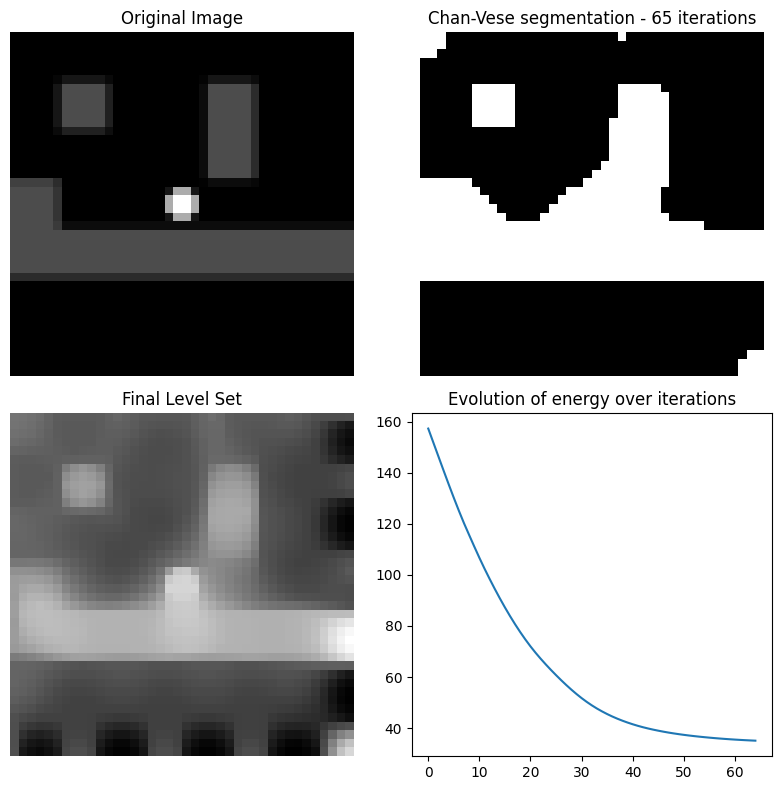

In [ ]:
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import chan_vese

image = img_as_float(img.permute(1, 2, 0).numpy()[:, :, 0])  # Use the red channel for segmentation
# Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(
    image,
    mu=0.25,
    lambda1=1,
    lambda2=1,
    tol=1e-3,
    max_num_iter=200,
    dt=0.5,
    init_level_set="checkerboard",
    extended_output=True,
)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = f'Chan-Vese segmentation - {len(cv[2])} iterations'
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

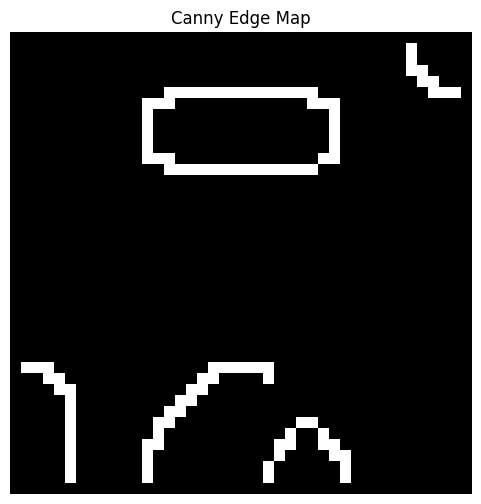

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature, transform

# Load the image
image_rgb = io.imread('../mains/agent_0_step_0.png')
image_gray = color.rgb2gray(image_rgb)

# Apply Canny edge detector
# The sigma (blur) and low/high thresholds may need tuning for your image
edges = feature.canny(image_gray, sigma=3, low_threshold=0.1, high_threshold=0.2)

# Display the detected edges
plt.figure(figsize=(6, 6))
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Map")
plt.axis('off')
plt.show()

In [ ]:
# Generate the Hough accumulator array
# The output 'H' is the accumulator, 'angles' and 'dists' are the parameter axes
H, angles, dists = transform.hough_line(edges)


# Find peaks in the accumulator array.
# 'num_peaks' controls how many of the strongest lines you detect.
# 'threshold' is the minimum vote count required for a line to be detected.
threshold_percent = 0.5  # Only detect peaks >= 50% of the maximum vote
threshold_value = int(H.max() * threshold_percent)

# Return the distance (d) and angle (a) corresponding to the peaks
# The peaks are sorted by vote count
peaks = transform.hough_line_peaks(H, angles, dists,
                                   threshold=threshold_value,
                                   num_peaks=20) # We'll look for up to 20 lines

H_d, H_a, H_dist = peaks # Unpack the results

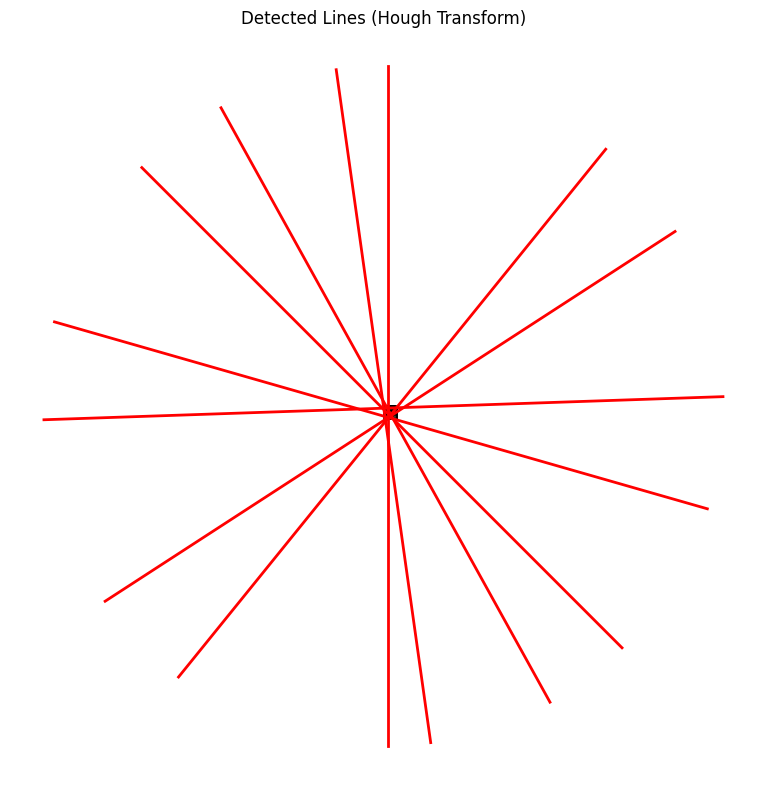

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(image_rgb)
ax.set_title('Detected Lines (Hough Transform)')
ax.set_axis_off()

# Iterate over the detected lines (peaks)
for distance, angle in zip(H_dist, H_a):
    # Convert polar coordinates (distance, angle) back to cartesian line endpoints
    
    # Calculate y-intercept (y0) and slope (x0) for the line passing through the origin
    # y0 = (distance - 0) / np.sin(angle)
    # x0 = (distance - 0) / np.cos(angle)

    # Assuming 'distance' is rho and 'angle' is theta (in radians)

    # 1. Find the point on the line closest to the origin (x_rho, y_rho)
    x_rho = distance * np.cos(angle)
    y_rho = distance * np.sin(angle)

    # 2. Define a very long line segment length
    line_len = 1000  # Adjust based on your image size, e.g., max(height, width)

    # 3. Calculate the endpoints (x1, y1) and (x2, y2)
    # The line is perpendicular to the vector (x_rho, y_rho)
    # The direction of the line is defined by (-sin(angle), cos(angle))

    x1 = int(x_rho + line_len * (-np.sin(angle)))
    y1 = int(y_rho + line_len * (np.cos(angle)))
    x2 = int(x_rho - line_len * (-np.sin(angle)))
    y2 = int(y_rho - line_len * (np.cos(angle)))

    # 4. Plot the line (Note: Axes usually need to be swapped for plotting)
    ax.plot((x1, x2), (y1, y2), '-r', linewidth=2)
    
    # Plot the line
    # ax.plot((y1, y2), (x1, x2), '-r', linewidth=2)

plt.tight_layout()
plt.show()

In [ ]:
coins = data.coins()
coins[0].shape

(384,)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()